# 基于lsa的文本相似度计算

#数据的导入与清理

In [2]:
##加载相关包
import jieba
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import silhouette_score ,calinski_harabasz_score,davies_bouldin_score

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
plot_kwds = {'alpha' : 0.7, 's': 40, 'linewidths':0,'cmap':'Set3'}

In [4]:
#导入数据
data=pd.read_excel('D:\wenben\8月12下午 文本分析\data\副本table_data.xlsx')
data=list(data['2020'])

文本数据清理，主要包括分词、去除标点符号停用词等

In [5]:
# 加载停用词
def get_stop_words(stop_words_dir):
    stop_words = []

    with open(stop_words_dir, 'r', encoding='utf-8') as f_reader:
        for line in f_reader:
            line = delete_r_n(line)
            stop_words.append(line)

    stop_words = set(stop_words)
    return stop_words

In [6]:
# 去掉空字符
def delete_r_n(line):
    return line.replace('\r', '').replace('\n', '').strip()

In [7]:
# 加载停用词,stopwords为停用词列表
stopwords = get_stop_words(r'D:\wenben\8月12下午 文本分析\停用词表.txt')

In [9]:
import jieba

# 加载自定义词典
jieba.load_userdict("D:\wenben\8月12下午 文本分析\data\mysele_pro.txt")  # 替换为您自己的词典文件路径

# 进行分词
text = [' '.join(jieba.lcut(doc)) for doc in data]


import jieba

# 加载自定义词典
jieba.load_userdict("custom_dict.txt")  # 替换为您自己的词典文件路径

# 进行分词
text = [' '.join(jieba.lcut(doc)) for doc in text]
在这个示例中，每行可以包含词语、词频和词性，用空格隔开。词频和词性是可选的，如果不提供，就只有词语本身。词频可以帮助结巴分词在分词时更准确地判断词语的重要性。词性用来指示词语的词性类别
这个词典需要用note 编码为utf_8

In [10]:
import re

# 仅处理字符串类型的元素
text = [' '.join(re.findall(r'[\u4e00-\u9fa5]+', str(doc))) if isinstance(doc, str) else '' for doc in data]

In [12]:
text = [' '.join(jieba.lcut(doc))
          for doc in text]
text

CountVectorizer
首先我们要明白，计算机是不能从文本字符串中发现规律的。只有将字符串编码为计算机可以理解的数字，计算机才有可能发现文本中的规律。

最容易理解的实现思路：

对文本编码，就是让词语与数字对应起来，建立基于给定文本的词典。（fit方法 ）
再根据词典对所有的文本数据进行转码。（transform方法）
scikit库的CountVectorize类就是这种思路。

In [13]:
#将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
wordcounter = CountVectorizer()

In [14]:
#将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
wordcounter = CountVectorizer()

In [15]:
#学习特征（构建词典）fit  并转化为特征矩阵。
matrix=wordcounter.fit_transform(text)
print(matrix.toarray())
#查看下特征与词语对应关系
print(wordcounter.get_feature_names_out())

[[0 0 1 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 3 0 0]
 [0 0 0 ... 0 0 0]]
['一万' '一不畅' '一业' ... '龙羊峡' '龙钢' '龙门']


In [16]:
#文档词频矩阵
pd.DataFrame(matrix.toarray(), columns = wordcounter.get_feature_names_out())

,一万,一不畅,一业,一丝不苟,一两个,一个,一主,一事,一二三,一云,...,龙洞,龙洲湾,龙港,龙游,龙潭,龙煤,龙琅,龙羊峡,龙钢,龙门
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,2,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
import pandas as pd

# 设置显示的最大行和最大列数
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 显示完整的文档词频矩阵
df_matrix = pd.DataFrame(matrix.toarray(), columns=wordcounter.get_feature_names_out())



print(df_matrix)

In [18]:
print(df_matrix.iloc[50:, :100])  

Empty DataFrame
Columns: [一万, 一不畅, 一业, 一丝不苟, 一两个, 一个, 一主, 一事, 一二三, 一云, 一些, 一人, 一亿, 一代人, 一代代, 一以贯之, 一件, 一份, 一企一策, 一企一证, 一优, 一会, 一会一节, 一位, 一体, 一体化, 一倍, 一关, 一减, 一刀切, 一分, 一分钱, 一切, 一制, 一刻钟, 一副, 一区, 一半, 一单, 一卡通, 一厂, 一厘, 一县, 一叶, 一号, 一同, 一名, 一周, 一品, 一园, 一圈, 一地, 一场, 一城, 一域, 一堂课, 一堡, 一增, 一大, 一大批, 一大步, 一天, 一套, 一如既往, 一季, 一季度, 一定, 一室, 一家, 一家亲, 一对一, 一小, 一局, 一届, 一屏, 一山, 一岗双责, 一岛, 一岭, 一市, 一带, 一幅, 一年, 一并, 一店, 一府两院, 一座, 一廊, 一建, 一开, 一张, 一强, 一往无前, 一律, 一户, 一扇门, 一手, 一打, 一批, 一抓到底]
Index: []


#奇异值分解

In [19]:
from sklearn.decomposition import TruncatedSVD  # LSA

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity




In [21]:
# 假设 matrix 是文档词频矩阵，其中每行是一个文档，每列是一个词语的词频
svd = TruncatedSVD(n_components=50)  # 选择降维后的维度
doc_features = svd.fit_transform(matrix)

# 计算文档之间的余弦相似度
doc_similarities = cosine_similarity(doc_features)

# 输出文档之间的相似性矩阵
print(doc_similarities)

[[1.         0.75310139 0.75964024 0.83582678 0.76925226 0.77467692
  0.81199946 0.80517995 0.83447336 0.78237325 0.80850539 0.84520025
  0.79466316 0.79435916 0.81027885 0.77213365 0.79606649 0.82916268
  0.81267753 0.78225077 0.81150367 0.82240608 0.77196985 0.820423
  0.78069506 0.78848905 0.79931208 0.84412389 0.80835842 0.7611143
  0.79552347]
 [0.75310139 1.         0.77096443 0.71988921 0.7861252  0.82245895
  0.75498053 0.79355676 0.81303741 0.78403384 0.78349297 0.80895734
  0.798145   0.81622443 0.81992276 0.73139268 0.80633541 0.80995325
  0.76225478 0.76405284 0.82945216 0.80848949 0.79730334 0.81078403
  0.77277866 0.81296476 0.81695148 0.79568579 0.80133248 0.77890945
  0.79206113]
 [0.75964024 0.77096443 1.         0.76364335 0.80080608 0.81024899
  0.78145024 0.84327819 0.81874506 0.7889741  0.78741348 0.79776506
  0.79803722 0.80972938 0.80561201 0.76414984 0.80177489 0.82791099
  0.76247857 0.78170912 0.8165325  0.81651548 0.82022104 0.81262508
  0.80401416 0.80768356

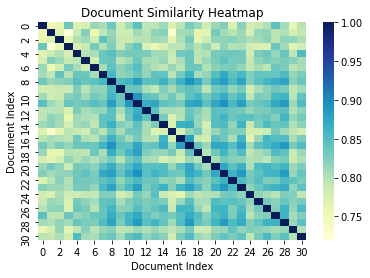

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
sns.heatmap(doc_similarities, cmap="YlGnBu")
plt.title("Document Similarity Heatmap")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()


In [23]:
lsa = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=200)
t1 = lsa.fit_transform(matrix)  # 训练并进行转化
print("--------lsa奇异值---------")
print(lsa.singular_values_)
print("--------500个文本，在10个话题向量空间下的表示---------")
print(t1)  # 500个文本，在10个话题向量空间下的表示

--------lsa奇异值---------
[1420.57118527  203.17834309  181.67021031  165.51312042  153.48347052
  138.43468792  131.98090053  130.62568844  123.00670406  122.29926732]
--------500个文本，在10个话题向量空间下的表示---------
[[ 2.11553456e+02  3.57191313e+01  1.32696551e+01 -6.96076799e+00
  -3.86739847e+01 -1.59906854e+01  1.57605799e+01 -1.11477425e+01
  -1.17995649e+01  2.22494223e+01]
 [ 2.13638866e+02 -5.41052609e+01  8.49741850e+00  1.38540598e+00
  -1.86252247e+01 -2.68502756e+00 -1.85050516e-01  5.73556317e+01
  -6.86147716e+00  3.86373612e+01]
 [ 1.53169949e+02 -2.01137043e+01  1.04316233e+01  2.58600668e+01
   2.90411309e+00 -1.36376067e+00  4.08935873e-01 -2.85620965e+00
  -3.64111546e+00 -4.58106358e+00]
 [ 3.22158618e+02  1.30797721e+02  5.00701852e+01  6.20801248e+01
  -4.61732477e+01  2.27369531e+01 -9.44518163e+00 -1.41664685e+00
   1.36505166e+00  3.02374349e+00]
 [ 2.53008085e+02 -2.67108128e+01  1.74473336e+01  7.35710646e+00
   3.66134897e+01  8.20536960e+01  1.46494180e+01 -1.6507545

In [24]:
###基于余弦相似度的文本相似性计算
from sklearn.metrics.pairwise import cosine_similarity

# 计算文档之间的余弦相似度
doc_similarities = cosine_similarity(t1)

# 输出文档之间的相似性矩阵
print(doc_similarities)

[[1.         0.86496899 0.90632862 0.93201381 0.84056231 0.85866747
  0.95397195 0.91598557 0.95310323 0.92435593 0.90330083 0.91817148
  0.8877242  0.88608019 0.93304925 0.83749374 0.88375955 0.94332045
  0.91769059 0.92066411 0.93180101 0.92558309 0.88737986 0.93008437
  0.90304107 0.91492662 0.91669341 0.93967795 0.94174479 0.83684539
  0.91518836]
 [0.86496899 1.         0.92072792 0.75415248 0.8535112  0.95624839
  0.84310353 0.90217291 0.90661253 0.90048436 0.85579962 0.86494816
  0.89832196 0.86506229 0.93126452 0.76339091 0.86197683 0.90577248
  0.82808544 0.89489347 0.94744246 0.89652557 0.89487126 0.90158121
  0.85801679 0.9495702  0.94003925 0.85524276 0.90946343 0.85830135
  0.91115664]
 [0.90632862 0.92072792 1.         0.85873657 0.93061104 0.93452203
  0.92385378 0.98585958 0.95682585 0.94456267 0.91106941 0.88411144
  0.90383443 0.92711689 0.94727924 0.88704683 0.91421324 0.96454827
  0.86539802 0.95378985 0.96651331 0.95525319 0.98069786 0.95972108
  0.95738309 0.98616

In [ ]:
##进一步探索与分析

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# 生成相似性表格
doc_similarities_df = pd.DataFrame(doc_similarities, columns=range(len(doc_similarities)))
print(doc_similarities_df)




          0         1         2         3         4         5         6   \
0   1.000000  0.864969  0.906329  0.932014  0.840562  0.858667  0.953972   
1   0.864969  1.000000  0.920728  0.754152  0.853511  0.956248  0.843104   
2   0.906329  0.920728  1.000000  0.858737  0.930611  0.934522  0.923854   
3   0.932014  0.754152  0.858737  1.000000  0.809153  0.830578  0.911361   
4   0.840562  0.853511  0.930611  0.809153  1.000000  0.839218  0.899719   
5   0.858667  0.956248  0.934522  0.830578  0.839218  1.000000  0.850369   
6   0.953972  0.843104  0.923854  0.911361  0.899719  0.850369  1.000000   
7   0.915986  0.902173  0.985860  0.863132  0.924722  0.922903  0.906173   
8   0.953103  0.906613  0.956826  0.872072  0.918388  0.907450  0.960483   
9   0.924356  0.900484  0.944563  0.858877  0.939290  0.904145  0.961851   
10  0.903301  0.855800  0.911069  0.863177  0.926620  0.886056  0.918543   
11  0.918171  0.864948  0.884111  0.857583  0.849312  0.877097  0.909164   
12  0.887724

In [28]:
excel_filename = "document2_similarity.xlsx"
doc_similarities_df.to_excel(excel_filename, index=False)
print("Excel file saved:", excel_filename)

Excel file saved: document2_similarity.xlsx


<ipython-input-28-037df8b11d16>:2: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.7' currently installed).
  doc_similarities_df.to_excel(excel_filename, index=False)


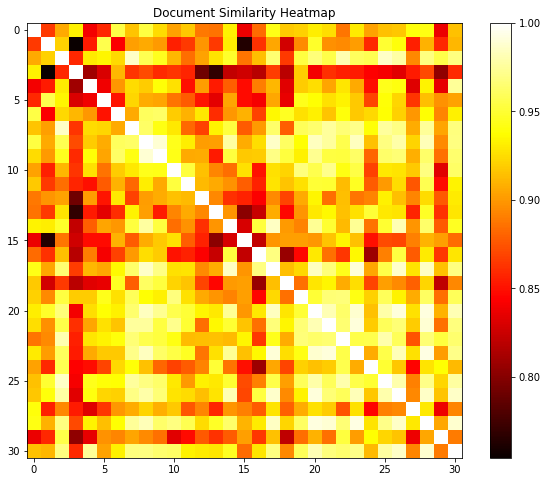

In [29]:
# 绘制热力矩阵图
plt.figure(figsize=(10, 8))
plt.imshow(doc_similarities, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Document Similarity Heatmap")
plt.show()